In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# ==========================
# 1. Load the Dataset
# ==========================
# Load the dataset (replace with your file path)
file_path = '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/Financial_risk_analysis_reduced.xlsx'
df = pd.read_excel(file_path)

# Display basic dataset info
print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

# ==========================
# 2. Handle Missing Values
# ==========================
# Fill missing values for numerical columns with the median
num_cols = [
    'CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 
    'SavingsAccountBalance', 'EmergencyFundBalance', 'RetirementAccountBalance', 
    'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 
    'PaymentHistory', 'NumberOfCreditInquiries', 'LengthOfCreditHistory'
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing values for categorical columns with the mode
cat_cols = [
    'EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus'
]
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify no missing values remain
print("\nMissing Values After Handling:")
print(df.isnull().sum())

# ==========================
# 3. Feature Engineering
# ==========================
# Add derived features for financial stability
df['SavingsToDebtRatio'] = df['SavingsAccountBalance'] / (df['TotalLiabilities'] + 1)
df['IncomeToLoanRatio'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)
df['MonthlySurplus'] = (df['AnnualIncome'] / 12) - df['MonthlyDebtPayments']

# Add interaction features to enhance weaker features
df['CreditScore_IncomeToLoan'] = df['CreditScore'] * df['IncomeToLoanRatio']
df['AnnualIncome_LoanAmount'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)

# Verify new features
print("\nNewly Engineered Features:")
print(df[['SavingsToDebtRatio', 'IncomeToLoanRatio', 'MonthlySurplus', 
         'CreditScore_IncomeToLoan', 'AnnualIncome_LoanAmount']].head())

# ==========================
# 4. Encode Categorical Variables
# ==========================
# Encode binary categorical variables with LabelEncoder
binary_cat_cols = ['HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus']
le = LabelEncoder()
for col in binary_cat_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encoding for nominal categorical variables
df = pd.get_dummies(df, columns=[
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'
], drop_first=True)

# Verify encoding
print("\nSample Data After Encoding:")
print(df.head())

# ==========================
# 5. Ensure All Features Are Numeric
# ==========================
# Define features (X) and target variable (y)
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print("\nNon-Numeric Columns Found:", non_numeric_cols)
    print("Please ensure all columns are encoded properly.")

# Force conversion to numeric (if needed)
X = X.apply(pd.to_numeric, errors='coerce')

# Verify no missing or non-numeric values remain
print("\nCheck for Missing Values in X After Conversion:")
print(X.isnull().sum())
X.fillna(0, inplace=True)  # Replace any remaining NaNs with 0

# ==========================
# 6. Feature Selection
# ==========================
# Calculate mutual information scores
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mutual_info
}).sort_values(by='Mutual_Information', ascending=False)

# Select features with mutual information > 0.004 (adjust threshold as needed)
selected_features = mutual_info_df[mutual_info_df['Mutual_Information'] > 0.004]['Feature'].tolist()
X = X[selected_features]

print("\nSelected Features After Mutual Information Selection:")
print(selected_features)

# ==========================
# 7. Address Class Imbalance with Random Oversampling
# ==========================
# Check class imbalance
print("\nTarget Class Distribution Before Oversampling:")
print(y.value_counts())

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

# Check new class distribution
print("\nBalanced Target Class Distribution:")
print(pd.Series(y_balanced).value_counts())

# ==========================
# 8. Feature Scaling
# ==========================
# Normalize numerical features using StandardScaler
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

# ==========================
# 9. Train-Test Split
# ==========================
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print("\nTraining and Testing Data Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# ==========================
# 10. Save Preprocessed Data
# ==========================
# Save the preprocessed data to files for reuse
X_train.to_csv('X_train_preprocessed.csv', index=False)
X_test.to_csv('X_test_preprocessed.csv', index=False)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.to_csv('y_train_preprocessed.csv', index=False)
y_test.to_csv('y_test_preprocessed.csv', index=False)

print("\nPreprocessed data saved successfully!")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CreditScore                 49999 non-null  int64  
 1   AnnualIncome                49999 non-null  int64  
 2   LoanAmount                  49999 non-null  int64  
 3   LoanDuration                49999 non-null  int64  
 4   Age                         49999 non-null  int64  
 5   EmploymentStatus            49999 non-null  object 
 6   MaritalStatus               49999 non-null  object 
 7   NumberOfDependents          49999 non-null  int64  
 8   EducationLevel              49999 non-null  object 
 9   HomeOwnershipStatus         49999 non-null  object 
 10  MonthlyDebtPayments         49999 non-null  int64  
 11  CreditCardUtilizationRate   49999 non-null  float64
 12  NumberOfOpenCreditLines     49999 non-null  int64  
 13  NumberOfCreditInq


Selected Features After Mutual Information Selection:
['CreditScore', 'CreditScore_IncomeToLoan', 'AnnualIncome', 'MonthlySurplus', 'LifeInsuranceStatus', 'IncomeToLoanRatio', 'AnnualIncome_LoanAmount', 'CarInsuranceStatus', 'MonthlyHealthcareCosts']

Target Class Distribution Before Oversampling:
0    31197
1    18802
Name: LoanApproved, dtype: int64

Balanced Target Class Distribution:
0    31197
1    31197
Name: LoanApproved, dtype: int64

Training and Testing Data Shapes:
X_train: (49915, 9) X_test: (12479, 9)
y_train: (49915,) y_test: (12479,)

Preprocessed data saved successfully!


X_train Shape: (49915, 9)
X_test Shape: (12479, 9)
y_train Shape: (49915,)
y_test Shape: (12479,)

Random Forest Performance:
Accuracy: 0.8010257232150012
ROC-AUC: 0.8248889327267271

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      6240
           1       0.72      1.00      0.83      6239

    accuracy                           0.80     12479
   macro avg       0.86      0.80      0.79     12479
weighted avg       0.86      0.80      0.79     12479



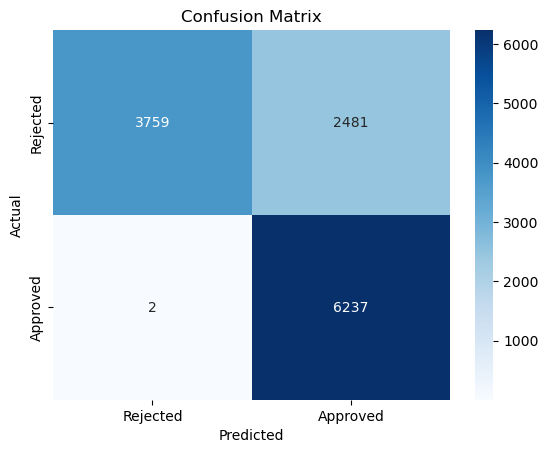


Feature Importance:
                    Feature  Importance
0               CreditScore    0.721716
1  CreditScore_IncomeToLoan    0.162053
2              AnnualIncome    0.035798
6   AnnualIncome_LoanAmount    0.027066
5         IncomeToLoanRatio    0.026642
3            MonthlySurplus    0.019343
8    MonthlyHealthcareCosts    0.006120
4       LifeInsuranceStatus    0.000676
7        CarInsuranceStatus    0.000585


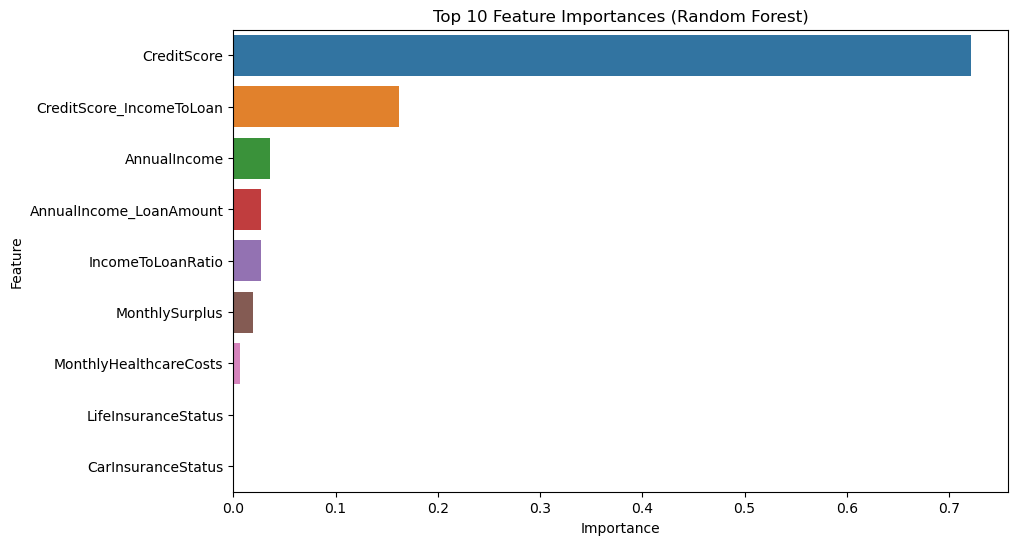

In [19]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Load Preprocessed Data
# ==========================
X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
y_train = pd.read_csv('y_train_preprocessed.csv').values.ravel()  # Convert to 1D array
y_test = pd.read_csv('y_test_preprocessed.csv').values.ravel()

# Display shapes to confirm
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

# ==========================
# Random Forest Model Building
# ==========================
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluation Metrics
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("ROC-AUC:", roc_auc_score(y_test, rf_probabilities))
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importances)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CreditScore                 49999 non-null  int64  
 1   AnnualIncome                49999 non-null  int64  
 2   LoanAmount                  49999 non-null  int64  
 3   LoanDuration                49999 non-null  int64  
 4   Age                         49999 non-null  int64  
 5   EmploymentStatus            49999 non-null  object 
 6   MaritalStatus               49999 non-null  object 
 7   NumberOfDependents          49999 non-null  int64  
 8   EducationLevel              49999 non-null  object 
 9   HomeOwnershipStatus         49999 non-null  object 
 10  MonthlyDebtPayments         49999 non-null  int64  
 11  CreditCardUtilizationRate   49999 non-null  float64
 12  NumberOfOpenCreditLines     49999 non-null  int64  
 13  NumberOfCreditInq


Sample Data After Encoding:
   CreditScore  AnnualIncome  LoanAmount  LoanDuration  Age  \
0          402         63295       18830            13   29   
1          735         55936       23729             1   42   
2          570         62547       19660             7   54   
3          406         46129       21674            23   25   
4          371         57725       12189            26   42   

   NumberOfDependents EducationLevel  MonthlyDebtPayments  \
0                   2      Doctorate                  675   
1                   3         Master                  508   
2                   3      Doctorate                  610   
3                   3    High School                  469   
4                   4         Master                  607   

   CreditCardUtilizationRate  NumberOfOpenCreditLines  ...  \
0                   0.144528                       11  ...   
1                   0.690435                        9  ...   
2                   0.388420           

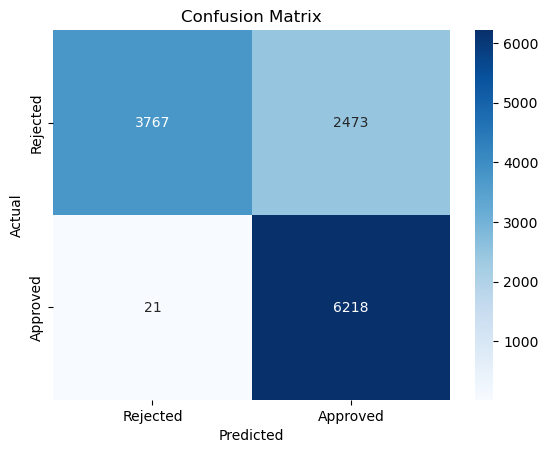

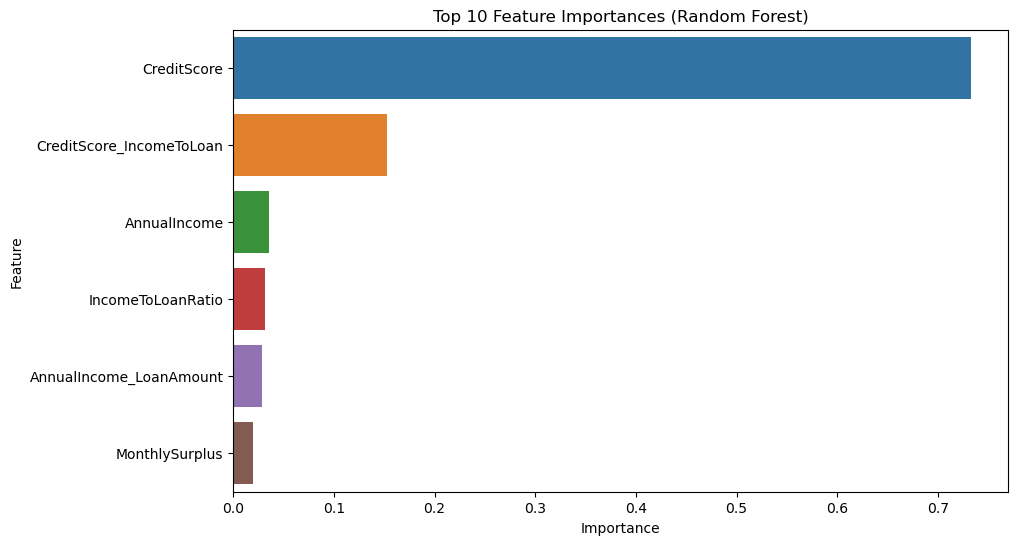

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# 1. Load the Dataset
# ==========================
file_path = '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/Financial_risk_analysis_reduced.xlsx'
df = pd.read_excel(file_path)

print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

# ==========================
# 2. Handle Missing Values
# ==========================
num_cols = [
    'CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 
    'SavingsAccountBalance', 'EmergencyFundBalance', 'RetirementAccountBalance', 
    'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 
    'PaymentHistory', 'NumberOfCreditInquiries', 'LengthOfCreditHistory'
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing Values After Handling:")
print(df.isnull().sum())

# ==========================
# 3. Feature Engineering
# ==========================
df['SavingsToDebtRatio'] = df['SavingsAccountBalance'] / (df['TotalLiabilities'] + 1)
df['IncomeToLoanRatio'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)
df['MonthlySurplus'] = (df['AnnualIncome'] / 12) - df['MonthlyDebtPayments']
df['CreditScore_IncomeToLoan'] = df['CreditScore'] * df['IncomeToLoanRatio']
df['AnnualIncome_LoanAmount'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)

# Additional Features
df['DebtBurden'] = df['DebtToIncomeRatio'] * df['MonthlyDebtPayments']
df['FinancialHealthIndex'] = df['SavingsAccountBalance'] - df['TotalLiabilities']
df['LoanPurpose_MonthlySurplus'] = df['MonthlySurplus'] * df['LoanAmount']

print("\nNewly Engineered Features:")
print(df[['SavingsToDebtRatio', 'IncomeToLoanRatio', 'MonthlySurplus', 
         'CreditScore_IncomeToLoan', 'AnnualIncome_LoanAmount',
         'DebtBurden', 'FinancialHealthIndex', 'LoanPurpose_MonthlySurplus']].head())

# ==========================
# 4. Encode Categorical Variables
# ==========================
binary_cat_cols = ['HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus']
le = LabelEncoder()
for col in binary_cat_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=[
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'
], drop_first=True)

print("\nSample Data After Encoding:")
print(df.head())

# ==========================
# 5. Define Features and Target
# ==========================
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# ==========================
# 6. Feature Selection
# ==========================
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mutual_info
}).sort_values(by='Mutual_Information', ascending=False)

selected_features = mutual_info_df[mutual_info_df['Mutual_Information'] > 0.005]['Feature'].tolist()
X = X[selected_features]

print("\nSelected Features After Mutual Information Selection:")
print(selected_features)

# ==========================
# 7. Address Class Imbalance with Random Oversampling
# ==========================
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

print("\nBalanced Target Class Distribution:")
print(pd.Series(y_balanced).value_counts())

# ==========================
# 8. Feature Scaling
# ==========================
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

# ==========================
# 9. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ==========================
# 10. Weighted Ensemble Model
# ==========================
# Define Models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Ensemble Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('log', log_model)
    ],
    voting='soft',  # Use probabilities
    weights=[2, 2, 1]  # Adjust weights
)

# Train Ensemble Model
ensemble_model.fit(X_train, y_train)

# Predictions
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_probabilities = ensemble_model.predict_proba(X_test)[:, 1]

# ==========================
# 11. Evaluate Model
# ==========================
print("\nEnsemble Model Performance:")
print("Accuracy:", accuracy_score(y_test, ensemble_predictions))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_probabilities))
print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================
# 12. Feature Importance
# ==========================
# Extract feature importance from Random Forest
rf_model.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CreditScore                 49999 non-null  int64  
 1   AnnualIncome                49999 non-null  int64  
 2   LoanAmount                  49999 non-null  int64  
 3   LoanDuration                49999 non-null  int64  
 4   Age                         49999 non-null  int64  
 5   EmploymentStatus            49999 non-null  object 
 6   MaritalStatus               49999 non-null  object 
 7   NumberOfDependents          49999 non-null  int64  
 8   EducationLevel              49999 non-null  object 
 9   HomeOwnershipStatus         49999 non-null  object 
 10  MonthlyDebtPayments         49999 non-null  int64  
 11  CreditCardUtilizationRate   49999 non-null  float64
 12  NumberOfOpenCreditLines     49999 non-null  int64  
 13  NumberOfCreditInq

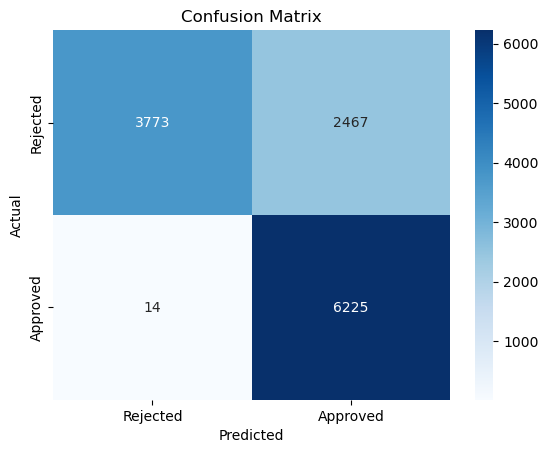

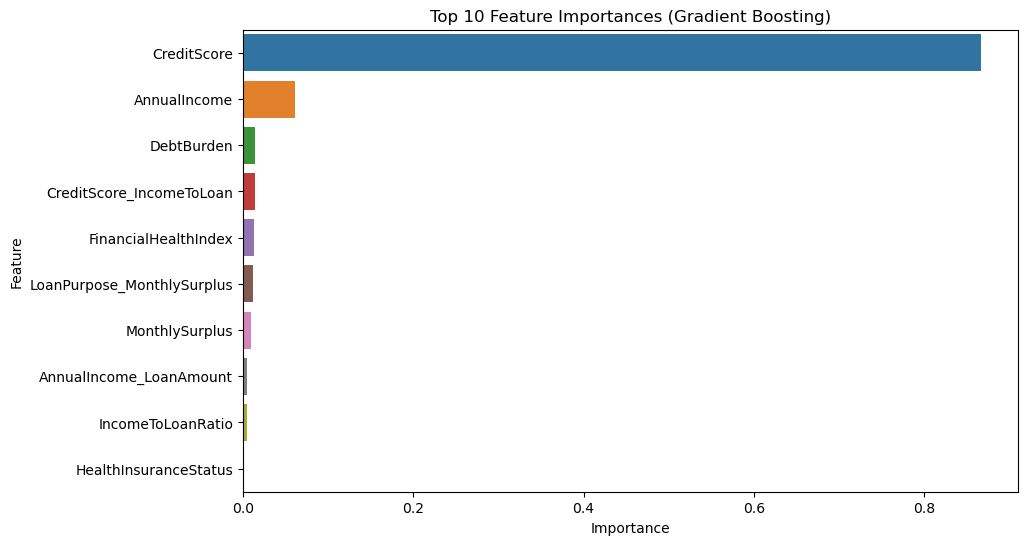


Preprocessed data saved successfully!


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# 1. Load the Dataset
# ==========================
file_path = '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/Financial_risk_analysis_reduced.xlsx'
df = pd.read_excel(file_path)

print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

# ==========================
# 2. Handle Missing Values
# ==========================
num_cols = [
    'CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 
    'SavingsAccountBalance', 'EmergencyFundBalance', 'RetirementAccountBalance', 
    'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 
    'PaymentHistory', 'NumberOfCreditInquiries', 'LengthOfCreditHistory'
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ==========================
# 3. Feature Engineering
# ==========================
# Derived Features
df['SavingsToDebtRatio'] = df['SavingsAccountBalance'] / (df['TotalLiabilities'] + 1)
df['IncomeToLoanRatio'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)
df['MonthlySurplus'] = (df['AnnualIncome'] / 12) - df['MonthlyDebtPayments']
df['CreditScore_IncomeToLoan'] = df['CreditScore'] * df['IncomeToLoanRatio']
df['AnnualIncome_LoanAmount'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)

# Additional Features
df['DebtBurden'] = df['DebtToIncomeRatio'] * df['MonthlyDebtPayments']
df['FinancialHealthIndex'] = df['SavingsAccountBalance'] - df['TotalLiabilities']
df['LoanPurpose_MonthlySurplus'] = df['MonthlySurplus'] * df['LoanAmount']

# ==========================
# 4. Encode Categorical Variables
# ==========================
binary_cat_cols = ['HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus']
le = LabelEncoder()
for col in binary_cat_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=[
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'
], drop_first=True)

# ==========================
# 5. Define Features and Target
# ==========================
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# ==========================
# 6. Feature Selection
# ==========================
# Calculate mutual information scores
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mutual_info
}).sort_values(by='Mutual_Information', ascending=False)

# Automatically select features with mutual information > 0.004
selected_features = mutual_info_df[mutual_info_df['Mutual_Information'] > 0.004]['Feature'].tolist()

# Force-Include Important Features
engineered_features = ['DebtBurden', 'FinancialHealthIndex', 'LoanPurpose_MonthlySurplus']
for feature in engineered_features:
    if feature not in selected_features:
        selected_features.append(feature)

X = X[selected_features]

# ==========================
# 7. Address Class Imbalance with Random Oversampling
# ==========================
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

# ==========================
# 8. Feature Scaling
# ==========================
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

# ==========================
# 9. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ==========================
# 10. Gradient Boosting Model
# ==========================
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:, 1]

print("\nGradient Boosting Model Performance:")
print("Accuracy:", accuracy_score(y_test, gb_predictions))
print("ROC-AUC:", roc_auc_score(y_test, gb_probabilities))
print("\nClassification Report:")
print(classification_report(y_test, gb_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, gb_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================
# 11. Feature Importance
# ==========================
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# ==========================
# 12. Save Preprocessed Data
# ==========================
X_train.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/X_train_preprocessed.csv', index=False)
X_test.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/X_test_preprocessed.csv', index=False)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/y_train_preprocessed.csv', index=False)
y_test.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/y_test_preprocessed.csv', index=False)

print("\nPreprocessed data saved successfully!")


/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 6 34 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw



Selected Features Using ANOVA:
['CreditScore', 'AnnualIncome', 'LoanAmount', 'UtilityBillsPaymentHistory', 'MonthlySurplus', 'MaritalStatus_Widowed']

Random Forest Performance:
Accuracy: 0.9451547155827311
ROC-AUC: 0.9651368163321183

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2308
           1       0.91      1.00      0.95      3089

    accuracy                           0.95      5397
   macro avg       0.96      0.94      0.94      5397
weighted avg       0.95      0.95      0.94      5397



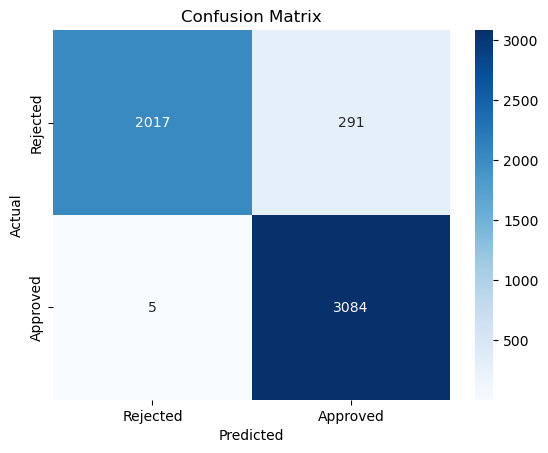

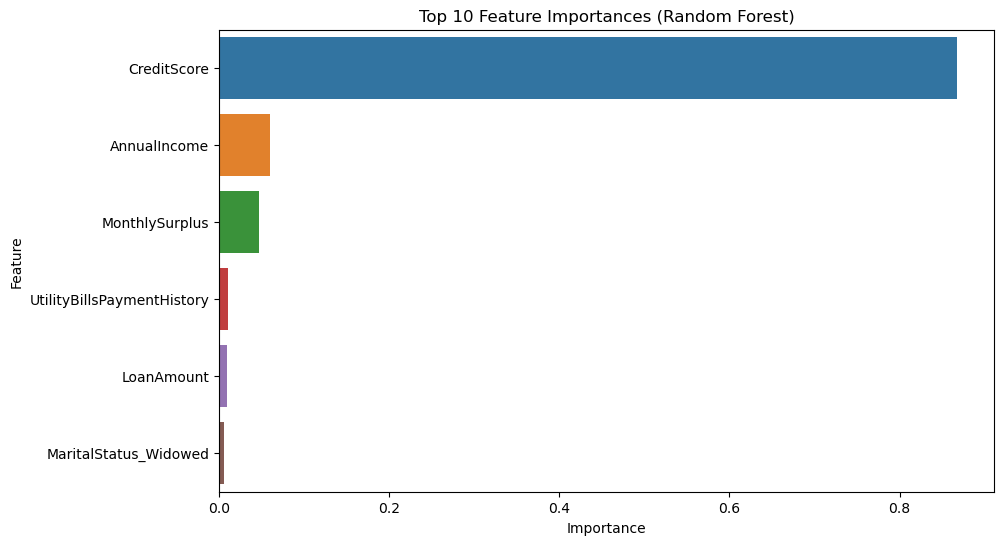


Preprocessed data saved successfully!


In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# 1. Load the Dataset
# ==========================
file_path = '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/Financial_risk_analysis_reduced.xlsx'
df = pd.read_excel(file_path)

# ==========================
# 2. Handle Missing Values
# ==========================
num_cols = [
    'CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 
    'SavingsAccountBalance', 'EmergencyFundBalance', 'RetirementAccountBalance', 
    'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 
    'PaymentHistory', 'NumberOfCreditInquiries', 'LengthOfCreditHistory'
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ==========================
# 3. Feature Engineering
# ==========================
# Simplified engineered features
df['IncomeToLoanRatio'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)
df['MonthlySurplus'] = (df['AnnualIncome'] / 12) - df['MonthlyDebtPayments']

# ==========================
# 4. Encode Categorical Variables
# ==========================
binary_cat_cols = ['HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus']
le = LabelEncoder()
for col in binary_cat_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=[
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'
], drop_first=True)

# ==========================
# 5. Define Features and Target
# ==========================
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# ==========================
# 6. Feature Selection with ANOVA
# ==========================
selector = SelectKBest(score_func=f_classif, k=6)  # Select top 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print("\nSelected Features Using ANOVA:")
print(selected_features)

# Subset X
X = X[selected_features]

# ==========================
# 7. Address Class Imbalance with SMOTEENN
# ==========================
smoteenn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smoteenn.fit_resample(X, y)

# ==========================
# 8. Feature Scaling
# ==========================
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

# ==========================
# 9. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ==========================
# 10. Random Forest Model
# ==========================
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("ROC-AUC:", roc_auc_score(y_test, rf_probabilities))
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================
# 11. Feature Importance
# ==========================
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# ==========================
# 12. Save Preprocessed Data
# ==========================
X_train.to_csv('/Users/shaiksaheer/Desktop/X_train_preprocessed.csv', index=False)
X_test.to_csv('/Users/shaiksaheer/Desktop/X_test_preprocessed.csv', index=False)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.to_csv('/Users/shaiksaheer/Desktop/y_train_preprocessed.csv', index=False)
y_test.to_csv('/Users/shaiksaheer/Desktop/y_test_preprocessed.csv', index=False)

print("\nPreprocessed data saved successfully!")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CreditScore                 49999 non-null  int64  
 1   AnnualIncome                49999 non-null  int64  
 2   LoanAmount                  49999 non-null  int64  
 3   LoanDuration                49999 non-null  int64  
 4   Age                         49999 non-null  int64  
 5   EmploymentStatus            49999 non-null  object 
 6   MaritalStatus               49999 non-null  object 
 7   NumberOfDependents          49999 non-null  int64  
 8   EducationLevel              49999 non-null  object 
 9   HomeOwnershipStatus         49999 non-null  object 
 10  MonthlyDebtPayments         49999 non-null  int64  
 11  CreditCardUtilizationRate   49999 non-null  float64
 12  NumberOfOpenCreditLines     49999 non-null  int64  
 13  NumberOfCreditInq

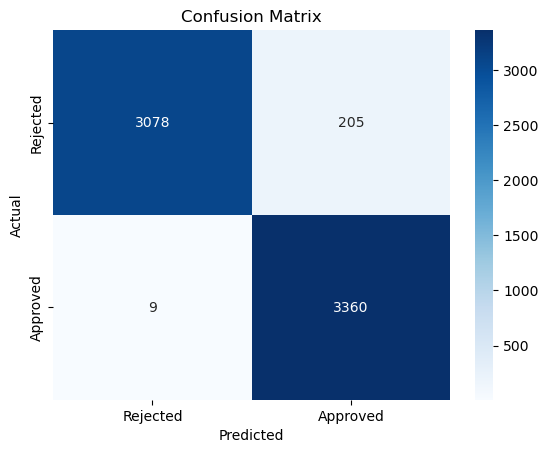

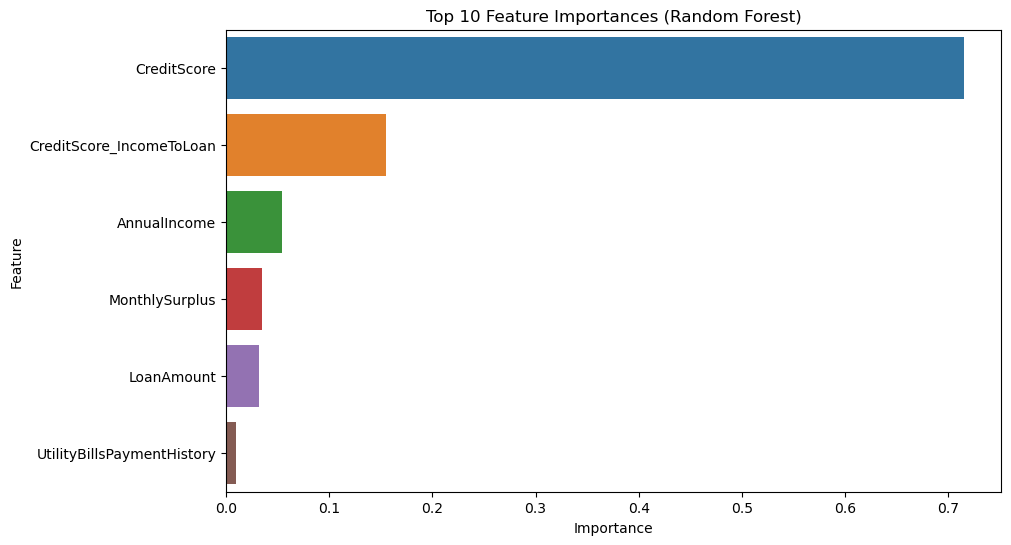


Enhanced Preprocessed Data and Model Saved Successfully!


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# 1. Load the Dataset
# ==========================
file_path = '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/Financial_risk_analysis_reduced.xlsx'
df = pd.read_excel(file_path)

print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

# ==========================
# 2. Handle Missing Values
# ==========================
num_cols = [
    'CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 
    'SavingsAccountBalance', 'EmergencyFundBalance', 'RetirementAccountBalance', 
    'MonthlyDebtPayments', 'TotalAssets', 'TotalLiabilities', 
    'PaymentHistory', 'NumberOfCreditInquiries', 'LengthOfCreditHistory'
]
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ==========================
# 3. Feature Engineering
# ==========================
df['IncomeToLoanRatio'] = df['AnnualIncome'] / (df['LoanAmount'] + 1)
df['MonthlySurplus'] = (df['AnnualIncome'] / 12) - df['MonthlyDebtPayments']
df['CreditScore_IncomeToLoan'] = df['CreditScore'] * df['IncomeToLoanRatio']

# ==========================
# 4. Encode Categorical Variables
# ==========================
binary_cat_cols = ['HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus']
le = LabelEncoder()
for col in binary_cat_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=[
    'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'
], drop_first=True)

# ==========================
# 5. Define Features and Target
# ==========================
X = df.drop('LoanApproved', axis=1)
y = df['LoanApproved']

X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# Identify and drop constant features
constant_features = [col for col in X.columns if X[col].nunique() == 1]
print(f"\nConstant Features Found: {constant_features}")
X.drop(columns=constant_features, inplace=True)

# Identify features with zero variance within each class
zero_variance_features = []
for col in X.columns:
    for label in y.unique():
        if X[y == label][col].nunique() == 1:
            zero_variance_features.append(col)
            break

# Drop zero variance features
zero_variance_features = list(set(zero_variance_features))
print(f"\nZero Variance Features Found: {zero_variance_features}")
X.drop(columns=zero_variance_features, inplace=True)


# ==========================
# 6. Feature Selection with ANOVA
# ==========================
selector = SelectKBest(score_func=f_classif, k=6)  # Adjust 'k' for top features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print("\nSelected Features Using ANOVA:")
print(selected_features)

X = X[selected_features]

# ==========================
# 7. Address Class Imbalance with SMOTEENN
# ==========================
smoteenn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smoteenn.fit_resample(X, y)

# ==========================
# 8. Feature Scaling
# ==========================
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

# Save the scaler for future use
joblib.dump(scaler, '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/scaler.pkl')

# ==========================
# 9. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ==========================
# 10. Hyperparameter Optimization for Random Forest
# ==========================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("\nBest Random Forest Parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

# ==========================
# 11. Ensemble Model
# ==========================
gb_model = GradientBoostingClassifier(random_state=42)
ensemble_model = VotingClassifier(estimators=[
    ('RandomForest', rf_best),
    ('GradientBoosting', gb_model)
], voting='soft')
ensemble_model.fit(X_train, y_train)

# Save the model
joblib.dump(ensemble_model, '/Users/shaiksaheer/Desktop/Loan_underwriting_Project/ensemble_model.pkl')

print("\nEnhanced Preprocessed Data and Model Saved Successfully!")

# ==========================
# 12. Evaluate the Model
# ==========================
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_probabilities = ensemble_model.predict_proba(X_test)[:, 1]

print("\nEnsemble Model Performance:")
print("Accuracy:", accuracy_score(y_test, ensemble_predictions))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_probabilities))
print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================
# 13. Feature Importance
# ==========================
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# ==========================
# 14. Save Preprocessed Data
# ==========================
X_train.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/X_train_preprocessed.csv', index=False)
X_test.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/X_test_preprocessed.csv', index=False)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/y_train_preprocessed.csv', index=False)
y_test.to_csv('/Users/shaiksaheer/Desktop/Loan_underwriting_Project/y_test_preprocessed.csv', index=False)

print("\nEnhanced Preprocessed Data and Model Saved Successfully!")



Sample Data Before Preprocessing:
   CreditScore  AnnualIncome  LoanAmount  LoanDuration  Age EmploymentStatus  \
0          402         63295       18830            13   29    Self-Employed   
1          735         55936       23729             1   42    Self-Employed   
2          570         62547       19660             7   54    Self-Employed   
3          406         46129       21674            23   25    Self-Employed   
4          371         57725       12189            26   42         Employed   

  MaritalStatus  NumberOfDependents EducationLevel HomeOwnershipStatus  ...  \
0       Widowed                   2      Doctorate               Other  ...   
1      Divorced                   3         Master                 Own  ...   
2        Single                   3      Doctorate            Mortgage  ...   
3      Divorced                   3    High School               Other  ...   
4       Widowed                   4         Master                 Own  ...   

   JobTen

/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- IncomeToLoanRatio
Feature names seen at fit time, yet now missing:
- LoanAmount
- UtilityBillsPaymentHistory

  warnings.warn(message, FutureWarning)


ValueError: X has 5 features, but StandardScaler is expecting 6 features as input.